In [45]:
import json
import requests
# import sweetviz as sv
# import ydata_profiling as pp
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import cross_val_score, KFold
from imblearn.over_sampling import SMOTE

In [3]:
import requests

# Define the base URL
url = "https://www.sephora.com/api/v2/catalog/search/"

# Define headers
headers = {
    "Accept": "application/json",  # Request JSON format
    "User-Agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/89.0.4389.82 Safari/537.36"
}

# Initialize an empty list to collect all data from each page
response_data = []

# Loop through pages 1 to 5
for i in range(1, 6):
    # Define the query parameters, changing the 'currentPage' parameter
    params = {
        "type": "keyword",
        "q": "foundation",
        "sddZipcode": "17013",
        "pickupStoreId": "800188",
        "includeEDD": "true",
        "content": "true",
        "includeRegionsMap": "true",
        "page": "60",
        "currentPage": i,
        "loc": "en-US",
        "ch": "rwd",
        "countryCode": "US",
        "constructorSessionID": "2",
        "constructorClientID": "fb972efe-533d-4c04-a488-ce71a66af361",
        "targetSearchEngine": "nlp"
    }

    # Make the GET request with parameters and headers
    response = requests.get(url, headers=headers, params=params)

    # Check if the response is successful
    if response.status_code == 200:
        try:
            # Attempt to parse JSON data
            data = response.json()
            # Add the parsed data to the response_data list
            response_data.extend(data.get('products', []))
            print(f"Data for page {i} collected successfully.")
        except ValueError:
            print(f"Response content for page {i} is not in JSON format.")
    else:
        print(f"Request failed for page {i} with status code: {response.status_code}")

# response_data now contains all products data from pages 1 to 5
print("Total products collected:", len(response_data))


Data for page 1 collected successfully.
Data for page 2 collected successfully.
Data for page 3 collected successfully.
Data for page 4 collected successfully.
Data for page 5 collected successfully.
Total products collected: 184


In [5]:
product_info = []
for product in response_data:
    product_info.append({'Product_Name':product['displayName'],
                         'Brand_Name':product.get('brandName','NA'),
                         'Price': product['currentSku']['listPrice'],
                         'Num_Colors': product.get('moreColors', 'NA'),
                         'Rating': product['rating'],
                         'Reviews': product['reviews'],
                         'isLimitedEdition': product['currentSku']['isLimitedEdition'],
                         'isSephoraExclusive': product['currentSku']['isSephoraExclusive'],
                         'isNatural': product['currentSku'].get('isNatural', 'NA'),
                         'isOrganic': product['currentSku'].get('isOrganic', 'NA'),
                         'isSponsored': product['sponsored']
                        })

In [7]:
import pandas as pd
df = pd.DataFrame(product_info)

In [9]:
df = df[df['Product_Name'].str.contains('Foundation',case = False, na= False)]
df = df[~df['Product_Name'].str.contains('Brush',case = False, na= False)]
df = df[~df['Product_Name'].str.contains('Pump',case = False, na= False)]
df = df[~df['Product_Name'].str.contains('Sample',case = False, na= False)]

In [21]:
df['isSponsored'] = df['isSponsored'].astype(int)
df['isLimitedEdition'] = df['isLimitedEdition'].astype(int)
df['isSephoraExclusive'] = df['isSephoraExclusive'].astype(int)
df['isNatural'] = df['isNatural'].replace('NA', 0).astype(int)
df['isOrganic'] = df['isOrganic'].replace('NA', 0).astype(int)

/var/folders/c0/xl2k8d6n0d389ydxqgtlgkfm0000gn/T/ipykernel_5961/1391572823.py:4: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df['isNatural'] = df['isNatural'].replace('NA', 0).astype(int)
/var/folders/c0/xl2k8d6n0d389ydxqgtlgkfm0000gn/T/ipykernel_5961/1391572823.py:6: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df['isOrganic'] = df['isOrganic'].replace('NA', 0).astype(int)


In [25]:
df['Price'] = df['Price'].astype(str)  # ensure all values are strings
df['Price'] = df['Price'].str.split(' - ').str[-1].str.replace('$','').astype(float)

In [27]:
df['Reviews'].astype(int)
df['Rating'].astype(float)
df['Num_Colors'] = pd.to_numeric(df['Num_Colors'], errors='coerce').astype('Int64') 

# EDA

In [31]:
df.shape

(112, 11)

In [35]:
df.drop_duplicates(keep='first', inplace=True)

In [37]:
df.reset_index(drop=True, inplace=True)

In [39]:
df

,Product_Name,Brand_Name,Price,Num_Colors,Rating,Reviews,isLimitedEdition,isSephoraExclusive,isNatural,isOrganic,isSponsored
0,Triclone Skin Tech Medium Coverage Foundation ...,HAUS LABS BY LADY GAGA,49.0,50,4.0175,4337,0,1,0,0,0
1,Liquid Touch Weightless Foundation,Rare Beauty by Selena Gomez,30.0,31,3.9508,5853,0,1,0,0,0
2,Double Wear Stay-in-Place 24-Hour Longwear Fou...,Estée Lauder,52.0,50,4.3603,7685,0,0,0,0,0
3,Luminous Silk Natural Glow Foundation,Armani Beauty,69.0,40,4.2285,6004,0,0,0,0,0
4,Backstage Face & Body Foundation,DIOR,45.0,43,4.354,5344,0,1,0,0,0
5,Light Reflecting Skin Improving Medium Coverag...,NARS,54.0,40,4.1045,2766,0,0,0,0,0
6,Born This Way Undetectable Medium-To-Full Cove...,Too Faced,48.0,30,4.5595,958,0,0,0,0,0
7,Mini Luminous Silk Natural Glow Foundation,Armani Beauty,48.0,38,4.2289,6012,0,0,0,0,0
8,SurrealSkin® Luminous Hydrating Foundation,MAKEUP BY MARIO,44.0,32,4.0652,3066,0,1,0,0,0
9,Soft’Lit Naturally Luminous Hydrating Longwear...,Fenty Beauty by Rihanna,42.0,50,4.4637,1803,0,0,0,0,0


In [531]:
df['Brand_Name'].value_counts().head(10)

MAKE UP FOR EVER              7
Fenty Beauty by Rihanna       6
DIOR                          5
IT Cosmetics                  4
ONE/SIZE by Patrick Starrr    4
Lancôme                       4
bareMinerals                  4
Urban Decay                   4
CLINIQUE                      4
Danessa Myricks Beauty        3
Name: Brand_Name, dtype: int64

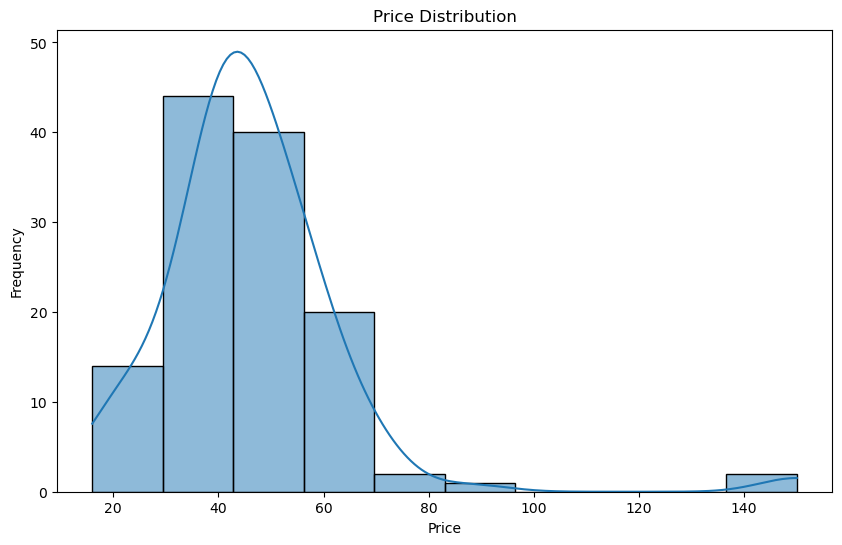

In [532]:
# Distribution of Price
plt.figure(figsize=(10, 6))
sns.histplot(df['Price'], kde=True, bins=10)
plt.title('Price Distribution')
plt.xlabel('Price')
plt.ylabel('Frequency')
plt.show()

In [41]:
df = df.dropna(subset=['Num_Colors'])

In [534]:
df = df.reset_index(drop=True)
df

,Product_Name,Brand_Name,Price,Num_Colors,Rating,Reviews,isLimitedEdition,isSephoraExclusive,isNatural,isOrganic,isSponsored
0,Luminous Silk Perfect Glow Flawless Oil-Free F...,Armani Beauty,69.0,39,4.2128,4742,0,0,0,0,0
1,Backstage Face & Body Foundation,DIOR,43.0,42,4.3619,5208,0,1,0,0,0
2,Triclone Skin Tech Medium Coverage Foundation ...,HAUS LABS BY LADY GAGA,49.0,50,4.0835,3678,0,1,0,0,0
3,Best Skin Ever Liquid Foundation,SEPHORA COLLECTION,22.0,49,4.1708,1651,0,1,0,0,0
4,Pro Filt’r Soft Matte Longwear Liquid Foundation,Fenty Beauty by Rihanna,40.0,50,4.0205,17422,0,0,0,0,0
5,SurrealSkin™ Luminous Hydrating Foundation,MAKEUP BY MARIO,44.0,59,4.0374,2833,0,1,0,0,0
6,Natural Radiant Longwear Full Coverage Foundation,NARS,52.0,33,3.6687,4039,0,0,0,0,0
7,Double Wear Stay-in-Place 24-Hour Longwear Fou...,Estée Lauder,52.0,55,4.3651,7556,0,0,0,0,0
8,Light Reflecting Advanced Skincare Medium Cove...,NARS,52.0,38,4.112,2616,0,0,0,0,0
9,Liquid Touch Weightless Foundation,Rare Beauty by Selena Gomez,30.0,39,3.9604,5778,0,1,0,0,0


# Model Predicting Price of Foundation Products

In [620]:
# Remove rows where Price > 100
df = df[df['Price'] <= 100]

# Reset the index after filtering
df.reset_index(drop=True, inplace=True)

print("Outliers removed. Dataset shape:", df.shape)

Outliers removed. Dataset shape: (118, 11)


In [621]:
# Select relevant features
X = df[['Brand_Name', 'Product_Name', 'Num_Colors', 'Rating', 'Reviews', 
          'isLimitedEdition', 'isSephoraExclusive']]
y = df['Price']

# Perform one-hot encoding on categorical variables
X_encoded = pd.get_dummies(X, columns=['Brand_Name', 'Product_Name'], drop_first=True)

In [622]:
# Initialize the model
model = RandomForestRegressor(n_estimators=100, random_state=42)

In [623]:
# Split data
X_train, X_test, y_train, y_test = train_test_split(X_encoded, y, test_size=0.2, random_state=42)

In [624]:
# Train the model on the entire training set
model.fit(X_train, y_train)

RandomForestRegressor(random_state=42)

In [625]:
# Predictions
y_pred = model.predict(X_test)

In [626]:
# Evaluation
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

print("\nImproved Model Evaluation Metrics:")
print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")
print(f"R-squared (R²): {r2:.2f}")


Improved Model Evaluation Metrics:
Root Mean Squared Error (RMSE): 11.18
R-squared (R²): -0.01


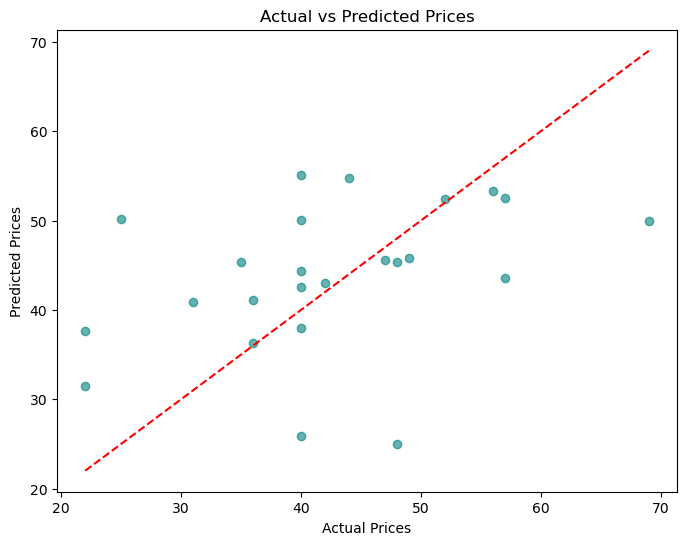

In [627]:
# Visualization of Predictions vs Actual Values
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred, color='teal', alpha=0.6)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')  # Ideal line
plt.xlabel("Actual Prices")
plt.ylabel("Predicted Prices")
plt.title("Actual vs Predicted Prices")
plt.show()

In [628]:
# Retrieve feature importances
importances = model.feature_importances_
feature_names = X_encoded.columns

# Create a DataFrame for feature importance
importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances})
importance_df = importance_df.sort_values(by='Importance', ascending=False)

In [629]:
# Define grouping logic
def group_feature_name(feature):
    if "Product_Name" in feature:
        return "Product_Name"
    elif "Brand_Name" in feature:
        return "Brand_Name"
    else:
        return feature

# Apply grouping
importance_df["Group"] = importance_df["Feature"].apply(group_feature_name)
grouped_importance = importance_df.groupby("Group")["Importance"].sum().reset_index()

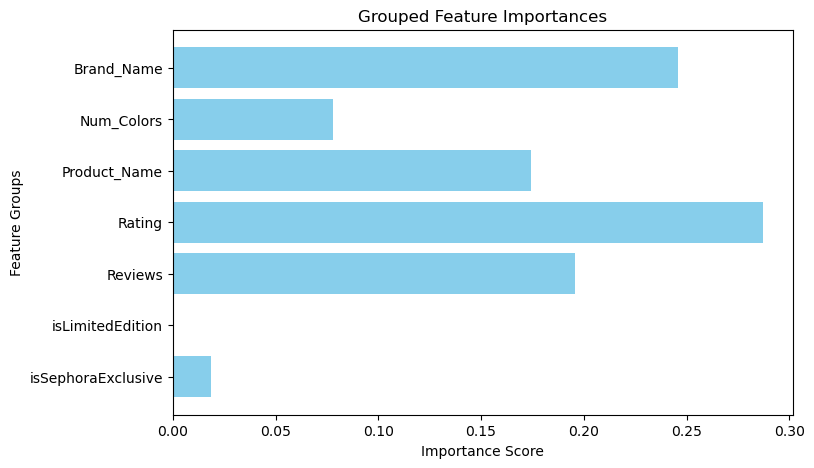

In [630]:
# Plot grouped feature importance
plt.figure(figsize=(8, 5))
plt.barh(grouped_importance["Group"], grouped_importance["Importance"], color="skyblue")
plt.gca().invert_yaxis()  # Invert y-axis for better visibility
plt.title("Grouped Feature Importances")
plt.xlabel("Importance Score")
plt.ylabel("Feature Groups")
plt.show()